# Python API to https://argovis.colorado.edu

This post is the first part of a three-part series into argovis.
1. [Argovis API](http://www.itsonlyamodel.us/argovis-python-api.html) introduces my website [argovis.colorado.edu](http://argovis.colorado.edu), and how users can access data using a python API. 
2. [Linear time series analysis in R](http://www.argo.ucsd.edu/r-time-series-fit.html) shows how time series models can be used to fit ocean temperatures from Argo data.
3. [Linear time series model fitting in python](http://www.argo.ucsd.edu/python-time-series-fit.html) gives further detail on how non-linear least squares fitting is typically done on time series. 

For over a decade, the [Argo](http://www.argo.ucsd.edu/index.html) program has provided temperature, salinity and pressure data (T/S/P) on a global scale for depths as far as 2000 dbar, with unprecedented spatial and temporal resolution and no seasonal bias. Close to two million profiles have been collected and made publicly available on Argo’s Global Data Assembly Centres (GDACs) on FTP servers. Unfortunately, online tools for selection and visualization of this big data set are limited slow to access.

In response, a webapp [argovis.colorado.edu](http://argovis.colorado.edu) attempts to improve data access. Overall, this website offers seamless navigation of the Argo dataset. Argo now has a maintainable, scalable, and portable tool written with representational state transfer (REST) architecture. RESTful design offers us the opportunity to feature cloud computing applications; chiefly, map comparison from existing gridded Argo products, as well as parameter estimation such as basin mean T/S/P.

The following code is an interface to argovis.com. HTTP 'get' requests access the web app's database, similar to a browser; however, there is no HTML or javascript. Essentially, this interface is used to query the same database that builds the website. The idea behind this approach is that we no longer rely on the browser to handle queries.

This script will guide a python user to:

[1. Query a specific profile its id, designated by its platform (WMO) number with its cycle number, connected by an underscore. For example '3900737_9'](#section_one)

[2. Query a specified platform by number. Example '3900737'.](#section_two)

[3 Query profiles within a given shape, date range, and pressure range.](#section_three)

[4. Plot query results](#section_four)

[5 Query profiles metadata within a month and year.](#section_five)

[6. Create time series given for a selection and set of dates.](#section_six)

[7. Query database using a gridded scheme](#section_seven)

[8. Plot gridded data using Cartopy](#section_eight)

Firstly, following libraries are called

In [1]:
import requests
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime
import pdb
import os

#used for map projections
from netCDF4 import Dataset as netcdf_dataset
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size": 10,
           "axes.titlesize": 20,
           "axes.labelsize": 20,
           'xtick.labelsize': 16,
           'ytick.labelsize': 16}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink", "green", "red", "brown"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

curDir = os.getcwd()
docDir = os.path.join(curDir, 'docs')

<a name="section_one"/> </a>
# 1. Get A Profile

The requests library handles HTTP get requests. If the message is received and the profile exists Argovis will return a JSON object. Python casts a JSON object as a native dictionary type. 

In [2]:
def get_profile(profile_number):
    resp = requests.get('https://argovis.colorado.edu/catalog/profiles/'+profile_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

The pandas dataframe object is better suited to handle manipulations. Essentially it is a spreadsheet.

In [3]:
profileDict = get_profile('3900737_279')
profileDf = pd.DataFrame(profileDict['measurements'])
profileDf['cycle_number'] = profileDict['cycle_number']
profileDf['profile_id'] = profileDict['_id']
profileDf.head()

,pres,psal,temp,cycle_number,profile_id
0,4.4,35.421,27.165,279,3900737_279
1,10.0,35.421,27.063,279,3900737_279
2,16.9,35.422,27.055,279,3900737_279
3,23.7,35.422,27.048,279,3900737_279
4,30.9,35.421,27.046,279,3900737_279


Through pandas, we can save this as a csv. 

In [4]:
profileDf.to_csv(os.path.join(docDir,'profile.csv'))

<a name="section_two"/> </a>
# 2. Get A Platform

A platform consists of a list of profiles. An additional function 'parse_into_df' appends each profile to one data frame.

In [15]:
def get_platform_profiles(platform_number):
    resp = requests.get('https://argovis.colorado.edu/catalog/platforms/'+platform_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    platformProfiles = resp.json()
    return platformProfiles

def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

In [16]:
platformProfiles = get_platform_profiles('3900737')
platformDf = parse_into_df(platformProfiles)
print('number of measurements {}'.format(platformDf.shape[0]))

number of measurements 24817


In [17]:
platformDf.head()

,temp,psal,pres,cycle_number,profile_id,lat,lon,date
0,29.200,35.547,4.2,352.0,3900737_352,-6.554,-167.147,2019-11-12T19:21:27.002Z
1,29.199,35.545,9.3,352.0,3900737_352,-6.554,-167.147,2019-11-12T19:21:27.002Z
2,29.193,35.544,16.3,352.0,3900737_352,-6.554,-167.147,2019-11-12T19:21:27.002Z
3,29.192,35.544,23.3,352.0,3900737_352,-6.554,-167.147,2019-11-12T19:21:27.002Z
4,29.146,35.554,30.4,352.0,3900737_352,-6.554,-167.147,2019-11-12T19:21:27.002Z


Dataframes can handle large arrays efficiently, thanks to the underlying numpy library. Pandas allows for easy and quick computations, such as taking the mean of the measurements.

In [18]:
platformDf[['pres', 'psal', 'temp']].mean(0)

pres    539.124374
psal     34.898826
temp     12.523647
dtype: float64

<a name="section_three"/> </a>
# 3. Get A Selection

A user quickly accesses profiles and platform data by searching the FTP site or using tools already in existence. Argovis goes one step further by querying with criteria such as:

* start date
* end date
* pressure range
* polygon of latitude-longitude coordinates

The code below allows pressure to be optional. 

In [19]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'https://argovis.colorado.edu/selection/profiles'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

In [20]:
startDate='2017-9-15'
endDate='2017-10-31'
# shape should be nested array with lon, lat coords.
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presRange='[0,30]'

selectionProfiles = get_selection_profiles(startDate, endDate, shape, presRange)
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)

Here we can get the mean measurements from September 15th until the 31st on the first 30 dbar or approximately the first 30 meters. 

Note that we probably should spatially average, but you get the picture!

In [22]:
selectionDf.head()

,temp,pres,psal,cycle_number,profile_id,lat,lon,date
0,23.054,6.0,36.948,81.0,6902664_81,32.535,-16.905,2017-10-29T19:44:00.000Z
1,23.052,7.0,36.948,81.0,6902664_81,32.535,-16.905,2017-10-29T19:44:00.000Z
2,23.045,8.0,36.948,81.0,6902664_81,32.535,-16.905,2017-10-29T19:44:00.000Z
3,23.039,9.0,36.948,81.0,6902664_81,32.535,-16.905,2017-10-29T19:44:00.000Z
4,23.036,10.0,36.948,81.0,6902664_81,32.535,-16.905,2017-10-29T19:44:00.000Z


<a name="section_four"/> </a>
# 4. Plotting results

Argovis's plotting capabilities are limited to what is coded in javascript. There are many plotting libraries out there, but in this example we can create plots on our machine, thereby allowing customization.

Contour plots created by interpolation can be created using this data. Below is an example one such field that uses cubic interpolation.

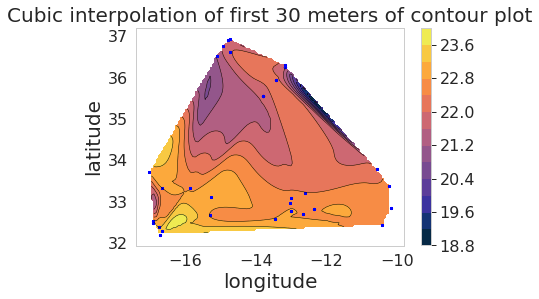

In [61]:
def contourPlot(df):
    fig = plt.figure()
    axes = plt.axes()
    xi = np.linspace(df['lon'].min(),df['lon'].max(),100)
    yi = np.linspace(df['lat'].min(),df['lat'].max(),100)
    
    x = df['lon'].values
    y = df['lat'].values
    z = df['temp'].values
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.thermal)
    axes.scatter(x,y,marker='o',c='b',s=5)
    axes.set_title('Cubic interpolation of first 30 meters of contour plot')

    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    cbar = fig.colorbar(CS, cmap = cmocean.cm.thermal)
    return fig

fig1 = contourPlot(selectionDf)

<a name="section_five"/> </a>
## 5. Selection of profiles metadata by Year and Date (position only)

For monthly profile distributions, meta data can be accessed quickly with the following code. This will be usefull in [section 8](#section_eight)

In [25]:
def get_monthly_profile_pos(month, year):
    baseURL = 'https://argovis.colorado.edu/selection/profiles'
    url = baseURL + '/' + str(month) + '/' + str(year)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    monthlyProfilePos = resp.json()
    return monthlyProfilePos

def parse_pos_into_df(profiles):
    df = pd.DataFrame(profiles)
    if df.shape[0] == 0:
        return 'error: no dataframes'
    return df

def bin_pos_df(df, delta):
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df

monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
monthlyDf.head()

,BASIN,DATA_MODE,PI_NAME,PLATFORM_TYPE,POSITIONING_SYSTEM,VERTICAL_SAMPLING_SCHEME,_id,containsBGC,cycle_number,dac,...,isDeep,lat,lon,platform_number,position_qc,pres_max_for_PSAL,pres_max_for_TEMP,pres_min_for_PSAL,pres_min_for_TEMP,station_parameters
0,2,D,Anja SCHNEEHORST,APEX,ARGOS,Primary sampling: discrete [],6901909_96,False,96,coriolis,...,False,68.336000,9.635000,6901909,1,1298.60,1298.60,5.20,5.20,"[temp, pres, psal]"
1,4,R,Pierre-Marie POULAIN,ARVOR,GPS,"Primary sampling: averaged [10 sec sampling, 2...",6901826_387,False,387,coriolis,...,False,36.995375,15.672915,6901826,1,630.60,630.60,6.30,6.30,"[temp, pres, psal]"
2,1,R,BRECK OWENS,S2A,GPS,Primary sampling: averaged [nominal 2 dbar bin...,1901665_196,False,196,aoml,...,False,-27.689920,9.441840,1901665,1,1005.08,1005.08,1.16,1.16,"[pres, psal, temp]"
3,10,R,Pierre-Marie POULAIN,ARVOR,GPS,"Primary sampling: averaged [10 sec sampling, 5...",6901838_113,False,113,coriolis,...,False,-56.073777,-130.715218,6901838,1,-999.00,1975.00,-999.00,7.90,"[temp, pres]"
4,3,A,ZENGHONG LIU,PROVOR,ARGOS,Primary sampling: averaged [],2902600_124,False,124,csio,...,False,-29.649000,93.720000,2902600,1,1983.00,1983.00,1.00,1.00,"[temp, psal, pres]"


In [31]:
myDR = pd.date_range('2004-01-01', '2018-01-01', periods=None, freq='M')
profTimeSeries = [];
for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    profTimeSeries.append({'date': date, 'nProf': len(monthlyProfilePos)})

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv(os.path.join(docDir,'profileTimeSeries.csv'))

In [32]:
profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv(os.path.join(docDir,'profileTimeSeries.csv'))

In [33]:
profTimeSeries = []
typeTimeSeries = []
psTimeSeries = []
dacTimeSeries = []

for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    monthlyDf = parse_pos_into_df(monthlyProfilePos)
    monthDict = {'date': date, 'nProf': len(monthlyProfilePos)}

    allDict = {}
    allDict.update(monthDict)
    
    platformType = monthlyDf.groupby('PLATFORM_TYPE')['_id'].count().to_dict()
    platformType.update(monthDict)
    typeTimeSeries.append(platformType)
    allDict.update(platformType)
    
    ps = monthlyDf.groupby('POSITIONING_SYSTEM')['_id'].count().to_dict()
    ps.update(monthDict)
    psTimeSeries.append(ps)
    allDict.update(ps)

    dac = monthlyDf.groupby('dac')['_id'].count().to_dict()
    dac.update(monthDict)
    dacTimeSeries.append(dac)
    allDict.update(dac)
    
    profTimeSeries.append(allDict)

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfileTimeSeries.csv'))

psTimeSeriesDf = pd.DataFrame(psTimeSeries)
psTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfilePositioningSystemTimeSeries.csv'))

typeTimeSeriesDf = pd.DataFrame(typeTimeSeries)
typeTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfileTypeTimeSeries.csv'))

dacTimeSeriesDf = pd.DataFrame(dacTimeSeries)
dacTimeSeriesDf.to_csv(os.path.join(docDir,'groupedDacTimeSeries.csv'))

In [34]:
profTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfileTimeSeries.csv'))
profTimeSeriesDf['date'] = pd.to_datetime(profTimeSeriesDf['date'])
profTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
psTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfilePositioningSystemTimeSeries.csv'))
psTimeSeriesDf['date'] = pd.to_datetime(psTimeSeriesDf['date'])
psTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
typeTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfileTypeTimeSeries.csv'))
typeTimeSeriesDf['date'] = pd.to_datetime(typeTimeSeriesDf['date'])
typeTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
dacTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedDacTimeSeries.csv'))
dacTimeSeriesDf['date'] = pd.to_datetime(dacTimeSeriesDf['date'])
dacTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)

In [36]:
def make_stack_plot(df, figsize=(6,3)):
    dataDf = df.drop(['date', 'nProf'], axis=1)
    fig = plt.figure(figsize=figsize)
    axes = plt.axes()
    axes.set_title('Number of profiles per month vs. time')
    axes.set_ylabel('# profiles/month')
    axes.set_xlabel('Date')
    axes.stackplot(df['date'].values, dataDf.T, labels=dataDf.columns)
    axes.legend(loc=2, fontsize=16)
    return fig

/home/tyler/anaconda3/envs/AR/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


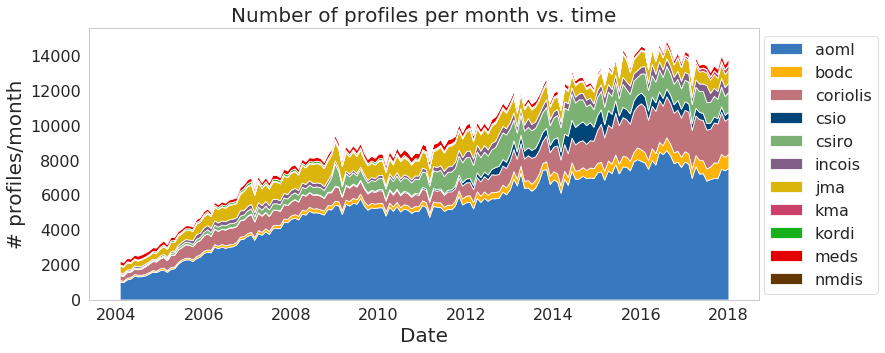

In [37]:
#sns.set_palette("husl")
fig = make_stack_plot(dacTimeSeriesDf, figsize=(12,5))
axes = plt.axes()
axes.legend(bbox_to_anchor=(1.19, 1.00), fontsize=16)

Here we can see which dacs are producing results over time. The next plot shows which transmission system the profiles are using. I lumped Iridium and GPS into one field. They are essentially equivalent.

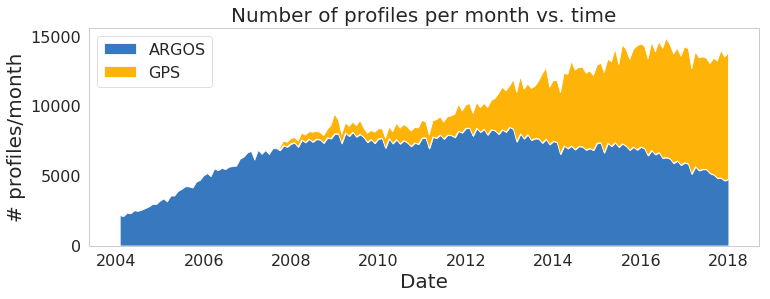

In [38]:
psdf=psTimeSeriesDf.copy()
psdf['GPS'] = psTimeSeriesDf['GPS'] + psTimeSeriesDf['IRIDIUM']
psdf.drop('GTS', axis = 1, inplace=True)
psdf.drop('IRIDIUM', axis = 1, inplace=True)
fig = make_stack_plot(psdf, figsize=(12,4))

<a name="section_six"/> </a>
# 6. Time Series

Stacking selection query averages 
Suppose that we average the temperature o selection query of Gibralter single value, and we give this value a time index. Repeating this process with an array of date ranges, we can create a time series. Just a disclaimer, this selection should be spatially averaged, but is left out; this is only a demonstration. 

In [40]:
def get_platform_measurements(profiles):
    '''
    Retrieves all measurements included in a list of platforms.
    '''
    stationParam = []
    for profile in profiles:
        stationParam.append(profile['station_parameters'])
    flatList = [item for sublist in stationParam for item in sublist]
    if isinstance(flatList[0], list):
        flatList = [item for sublist in flatList for item in sublist]
    uniqueList = list(set(flatList))
    uniqueList = [s for s in uniqueList if s != ''] # ignore blank station params.
                
    measurement_keys = [x.lower() for x in uniqueList]   
    return measurement_keys

def get_dates_set(period=30):
    n_rows = int(np.floor(365/period))
    datesSet = []
    for year in range(2004, 2018):
        yearSet = np.array_split(pd.date_range(str(year)+'-01-01', str(year)+'-12-31'), n_rows)
        datesSet = datesSet + yearSet
    keepEnds = lambda x: [x[0].strftime(format='%Y-%m-%d'), x[-1].strftime(format='%Y-%m-%d')]
    datesSet = list(map(keepEnds, datesSet))
    return datesSet

def get_ocean_time_series(seriesStartDate, seriesEndDate, shape, presRange='[0, 30]'):
    """
    Queries argovis database over long time scales but over one shape.
    shape should have a radius of no more than a few degrees.
    Pressure range should about 10-50 dbar.
    """
    
    selectionProfiles = get_selection_profiles(seriesStartDate, seriesEndDate, shape, presRange)
    if len(selectionProfiles) == 0:
        return
    meas_keys = get_platform_measurements(selectionProfiles)
    meas_keys = [s for s in meas_keys if s != ''] # ignore profiles that dont report anything
    print('Selection measurements: {}'.format(meas_keys))
    df = parse_into_df(selectionProfiles)
    
    #provide a time index for date ranges
    datesSet = get_dates_set(31)
    dateFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    df['date'] =  pd.to_datetime(df['date'], format=dateFormat)
    for idx, dates in enumerate(datesSet):
        startDate = datetime.strptime(dates[0], '%Y-%m-%d')
        endDate = datetime.strptime(dates[1], '%Y-%m-%d')
        try:
            if df[ (df['date'] < endDate) & (df['date'] > startDate)].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'tIndex'] = idx
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'startDate'] = startDate
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'endDate'] = endDate
        except ValueError:
            pdb.set_trace()
            df[ (df['date'] < startDate) & (df['date'] > endDate)].shape[0]

    df = df[np.isfinite(df['tIndex'])]
    #group and aggregate over tIndex
    tsDf = pd.DataFrame()
    grouped = df.groupby('tIndex')

    for tdx, group in grouped:
        nMeas = group.shape[0]
        if nMeas == 0:
            continue
        try:
            aggMean = group[meas_keys][group[meas_keys] != -999].mean()
            aggStd = group[meas_keys][group[meas_keys] != -999].std()
        except KeyError:
            pdb.set_trace()
            grouped.columns
        startDate = group['startDate'].values[0]
        endDate = group['endDate'].values[0]
        for key in meas_keys:
            tsDf.at[tdx, key+'Mean'] = aggMean[key]
            tsDf.at[tdx, key+'Std'] = aggStd[key]
        tsDf.at[tdx, 'startDate'] = startDate
        tsDf.at[tdx, 'endDate'] = endDate
        tsDf.at[tdx, 'nProf'] = nMeas
    return tsDf

In [41]:
tsDf = get_ocean_time_series('2004-01-01', '2017-12-31', shape, presRange='[0, 30]')
tsDf.to_csv(os.path.join(docDir,'gilbralter.csv'))

Selection measurements: ['psal', 'pres', 'cndc', 'temp']


Text(0.5, 0, '$Year$')

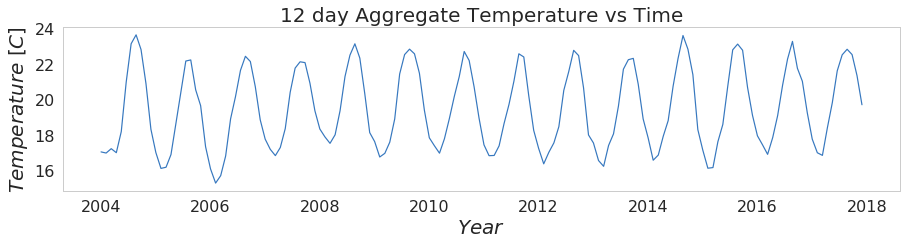

In [42]:
tsDf = pd.read_csv(os.path.join(docDir,'gilbralter.csv'))
#tsDf = tsDf[['tempMean', 'cndcMean' 'psalMean', 'tempStd', 'psalStd', 'startDate', 'endDate', 'nProf']]
tsDf['startDate'] = pd.to_datetime(tsDf['startDate'])
tsDf['endDate'] = pd.to_datetime(tsDf['endDate'])
fig = plt.figure(999, figsize=(15,3))
axes = plt.axes()
temp = tsDf['tempMean'].values
time = tsDf['startDate'].values
axes.plot(time, temp)
axes.set_title(r'12 day Aggregate Temperature vs Time')
axes.set_ylabel(r'$Temperature\ [C]$')
axes.set_xlabel(r'$Year$')

<a name="section_seven"/> </a>
# 7. Query by grid 

Where the get_ocean_time_series function goes through long time ranges, the get_ocean_df_from_csv queries a large grid over a short period of time.  

In [43]:
def get_ocean_df(oceanFileName, subGrid=None):
    """
    Retrieves gridded data used for get_ocean_df_from_csv and filters out to subGrid if exists.
    """
    oceanDf = pd.read_csv(oceanFileName)
    oceanDf.set_index('idx', inplace=True)
    if type(subGrid) != type(None):
        oceanDf = oceanDf[(oceanDf.lat >= subGrid['latMin']) &
                          (oceanDf.lat <= subGrid['latMax']) &
                          (oceanDf.lon >= subGrid['lonMin']) &
                          (oceanDf.lon <= subGrid['lonMax'])]
        print('oceanDF searching for {} areas'.format(oceanDf.shape[0]))
    return oceanDf

def get_pres_intervals(minPres, maxPres, dPres):
    """
    Creates an array of pressure intervalues used to break the grid up into vertical elements
    """
    presBin = np.arange(minPres, maxPres+dPres, dPres)
    presIntervals = []
    for idx, pres in enumerate(presBin[0:-1]):
        interval = presBin[idx:idx+2]
        presIntervals.append([idx, interval])
    return presIntervals


def get_ocean_df_from_csv(oceanDfCoords, startDate, endDate, presRange, presIntervals, nElem):
    """queries argovis database over large gridded space and small time scales.
    Ocean file name contains coordinates.
    Output is saves as a csv.
    Start date and End date are usually about 10-30 days
    """
    for row in oceanDfCoords.itertuples():
        shapeStr = '['+str(row.shape)+']'
        selectionProfiles = get_selection_profiles(startDate, endDate, shapeStr, presRange)
        if len(selectionProfiles) == 0:
            continue
        df = parse_into_df(selectionProfiles)
        if df.shape[0] == 0: #  move on if selection profiles don't turn up anything.
            continue
        # aggregate into pressure intervals            
        for ldx, pres in presIntervals:
            try:
                if df[ (df['pres'] < pres[1]) & (df['pres'] > pres[0])].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'ldx'] = ldx
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'presMin'] = pres[0]
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'presMax'] = pres[1]
            except ValueError:
                pdb.set_trace()
                df[ (df['pres'] < pres[1]) & (df['pres'] > pres[0])].shape[0]
        if not 'ldx' in df.columns:  # sometimes there are no measurements in the given pressure intervals
            continue
        try:
            grouped = df.groupby('ldx')
        except KeyError:
            pdb.set_trace()
            df.shape
        for ldx, group in grouped:
            nMeas = group.shape[0]
            if nMeas == 0:
                continue
            try:
                if not 'psal' in group.columns:
                    group['psal'] = np.nan
                if not 'temp' in group.columns:
                    group['temp'] = np.nan
                aggMean = group[['temp', 'psal']].mean()
            except:
                pdb.set_trace()
                asdf = 'aasdf'

            idx = row.Index + ldx * nElem
            oceanDf.set_value(idx, 'aggTemp', aggMean.temp)
            oceanDf.set_value(idx, 'aggPsal', aggMean.psal)
            oceanDf.set_value(idx, 'nProf', nMeas)
    oceanDf.dropna(axis=0, how='any', thresh=2, subset=['aggTemp', 'aggPsal', 'nProf'], inplace=True)
    return oceanDf

In [45]:
oceanFileName = './out/oceanCoordsAtOneDeg.csv'
nElem = 180 * 360
presRange = '[0, 30]' #  used to query database
startDate='2017-10-15'
endDate='2017-10-30'
minPres = 0 #  breaks up query into levels
maxPres = 30
dPres = 30
oceanDfCoords = get_ocean_df(oceanFileName)
presIntervals = get_pres_intervals(minPres, maxPres, dPres)

oceanDf is generated from one degree grids with land masks, provided by JPL. THe citation is below. Any grid point with 50 percent land or higher is omitted from oceanDf. Half and quarter degree grids are available.

Jet Propulsion Laboratory. 2013. ISLSCP II Land and Water Masks with Ancillary Data. Data set. Available on-line [http://daac.ornl.gov/] from Oak Ridge National Laboratory Distributed Active Archive Center, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1200

In [ ]:
oceanDf = get_ocean_df_from_csv(oceanDfCoords, startDate, endDate, presRange, presIntervals, nElem)
shallowPath = os.path.join(docDir,'shallow_one_deg_grid.csv')
oceanDf.to_csv(shallowPath)

In [50]:
oceanDf = pd.read_csv(shallowPath)
oceanDf.index=oceanDf.idx

In [53]:
#used for gridding purposes
worldGridPath = os.path.join(docDir,'worldGridAtOneDeg.csv')
worldGrid = pd.read_csv(worldGridPath)
worldGrid.index=worldGrid.idx
oceanGrid = pd.concat([oceanDf[['nProf', 'aggTemp', 'aggPsal']], worldGrid[['lat', 'lon']]], axis=1, join='outer')
oceanGrid.fillna(0, inplace=True)

<a name="section_eight"/> </a>
# 8. Plot on map projections

There are a few options in python when plotting on map projections. I am familiar with [Cartopy](http://scitools.org.uk/cartopy/). 

The chart below plots the number of profiles for each 1 by 1 degree cell.

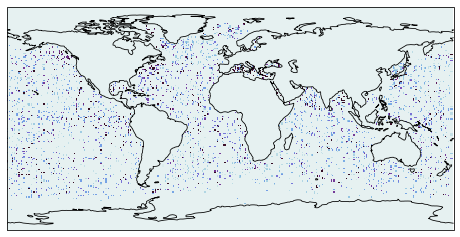

In [54]:
def plot_pmesh(df):
    fig = plt.figure(figsize=(8,12))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values.reshape(180,360)
    y = df['lat'].values.reshape(180,360)
    z = df['nProf'].values.reshape(180,360)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    plt.pcolormesh(x, y, z,vmax=40, cmap=cmocean.cm.dense, transform=ccrs.PlateCarree(),zorder=0)
    return fig

df = oceanGrid
pmeshfig = plot_pmesh(df)
plt.show()

# Conclusion

The three main functions described in sections 1, 2, and 3 can be written in a number or languages, such as R or Matlab. This project is still new, and will continue to evolve and improve. Feel free to email tyler.tucker@colorado.edu for questions/requests. Thanks!